In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("final_ds.csv")

date_time = pd.to_datetime(df.pop('Start Time'), format='%Y.%m.%d %H:%M:%S')
town = df.pop("NE Name")

In [3]:
date_time

0     2020-09-23 00:00:00
1     2020-09-23 01:00:00
2     2020-09-23 02:00:00
3     2020-09-23 03:00:00
4     2020-09-23 04:00:00
              ...        
716   2020-10-23 07:00:00
717   2020-10-23 08:00:00
718   2020-10-23 09:00:00
719   2020-10-23 10:00:00
720   2020-10-23 11:00:00
Name: Start Time, Length: 721, dtype: datetime64[ns]

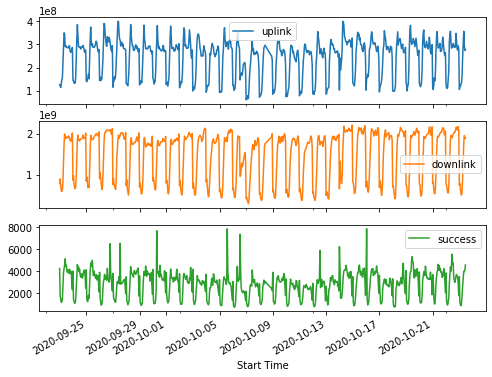

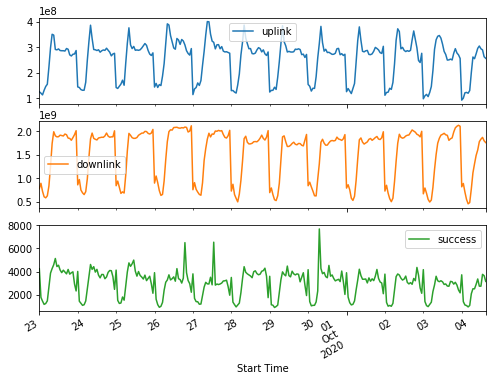

In [4]:
plot_cols = ['uplink', 'downlink', 'success']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:280]
plot_features.index = date_time[:280]
_ = plot_features.plot(subplots=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratio,721.0,9.891635e+01,4.534373e+00,8.485000e+00,9.902700e+01,9.931000e+01,9.951600e+01,1.000000e+02
maximum,721.0,9.168861e+03,1.207344e+03,5.422000e+03,8.366000e+03,9.209000e+03,1.009700e+04,1.248300e+04
success,721.0,2.864417e+03,1.150683e+03,7.130000e+02,2.077000e+03,3.012000e+03,3.615000e+03,7.865000e+03
uplink,721.0,2.463331e+08,7.932049e+07,5.946417e+07,1.828928e+08,2.746750e+08,2.971823e+08,4.002718e+08
downlink,721.0,1.496021e+09,5.835980e+08,2.913374e+08,8.508385e+08,1.802765e+09,1.949052e+09,2.208989e+09


In [6]:
df

,ratio,maximum,success,uplink,downlink
0,100.000,8842.0,4243.0,125672413.0,7.808551e+08
1,100.000,8029.0,1761.0,120271721.0,8.943131e+08
2,100.000,7511.0,1432.0,113310665.0,7.235221e+08
3,100.000,7260.0,1151.0,131486406.0,6.064117e+08
4,100.000,7045.0,1228.0,146347596.0,5.845472e+08
...,...,...,...,...,...
716,99.358,8861.0,3405.0,304610522.0,1.345308e+09
717,99.180,9597.0,3993.0,357282434.0,1.774680e+09
718,99.248,10287.0,3959.0,294613620.0,1.952499e+09
719,99.539,10400.0,4100.0,274070188.0,1.882121e+09


# Coordonnées du Temps

In [7]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [8]:
timestamp_s

0      1.600816e+09
1      1.600819e+09
2      1.600823e+09
3      1.600826e+09
4      1.600830e+09
           ...     
716    1.603433e+09
717    1.603436e+09
718    1.603440e+09
719    1.603444e+09
720    1.603447e+09
Name: Start Time, Length: 721, dtype: float64

In [9]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

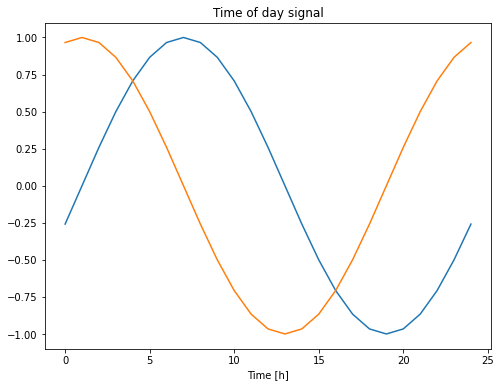

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

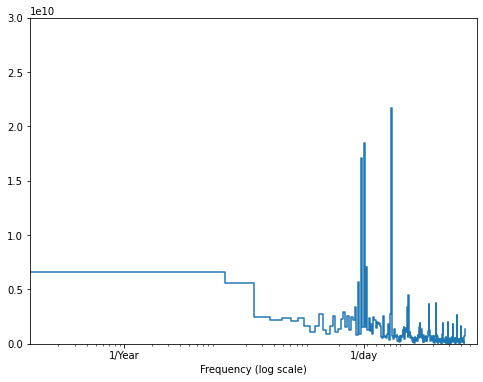

In [16]:
# connaitre a quel moment, on a une frequence importantz, on peut utiliser les transofrmer de fourier fft
fft = tf.signal.rfft(df['uplink'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['uplink'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 30000000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Dataset

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normaliser les données

on utilise generalement la normalisation pour ne pas donnée les donnée réel au model. 
 pour le faire, on soustrait la moitié, et divise par l'ecart type de chaque entité

In [18]:
train_df

,ratio,maximum,success,uplink,downlink,Day sin,Day cos,Year sin,Year cos
0,100.000,8842.0,4243.0,125672413.0,7.808551e+08,-2.588190e-01,9.659258e-01,-0.990311,-0.138867
1,100.000,8029.0,1761.0,120271721.0,8.943131e+08,6.915434e-13,1.000000e+00,-0.990410,-0.138157
2,100.000,7511.0,1432.0,113310665.0,7.235221e+08,2.588190e-01,9.659258e-01,-0.990509,-0.137447
3,100.000,7260.0,1151.0,131486406.0,6.064117e+08,5.000000e-01,8.660254e-01,-0.990607,-0.136737
4,100.000,7045.0,1228.0,146347596.0,5.845472e+08,7.071068e-01,7.071068e-01,-0.990705,-0.136027
...,...,...,...,...,...,...,...,...,...
499,99.366,11402.0,2822.0,400271847.0,1.536831e+09,9.659258e-01,2.588190e-01,-0.974516,0.224317
500,99.554,11729.0,3570.0,399555357.0,1.834212e+09,1.000000e+00,1.346590e-11,-0.974355,0.225015
501,99.630,12021.0,4034.0,381747067.0,2.178224e+09,9.659258e-01,-2.588190e-01,-0.974194,0.225713
502,99.584,12154.0,4067.0,339674084.0,2.095709e+09,8.660254e-01,-5.000000e-01,-0.974032,0.226412


In [19]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

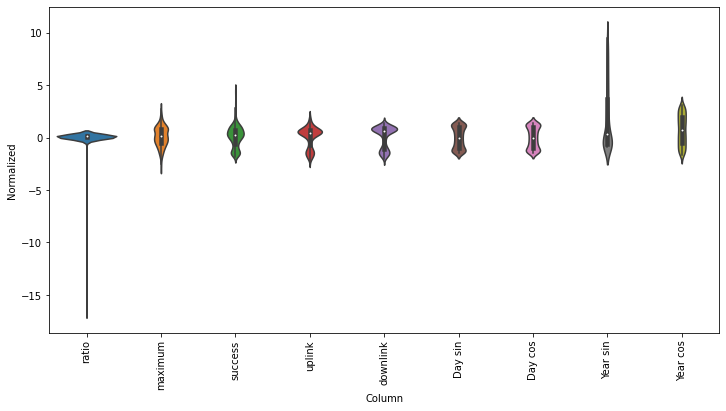

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Window data

1. generateur de fenetre

In [21]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [22]:
w = WindowGenerator(input_width=30,
                   label_width=1,
                   shift=30,
                   label_columns=['success'])

2. Fractionner

In [23]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
WindowGenerator.split_window = split_window

3. Tracée

In [24]:
def plot(self, model=None, plot_col='ratio', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

4. Make dataset

In [25]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [26]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [27]:
# Each element is an (inputs, label) pair
w.train.element_spec

(TensorSpec(shape=(None, 30, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [28]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 9)
Labels shape (batch, time, features): (32, 1, 1)


# RNN, pour la mesure de performance

In [29]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [40]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [41]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['maximum'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['maximum']

In [42]:
history = compile_and_fit(lstm_model, wide_window)


Epoch 1/200
15/15 [==============================] - 0s 19ms/step - loss: 0.9481 - mean_absolute_error: 0.7912 - val_loss: 0.7699 - val_mean_absolute_error: 0.7295
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5201 - mean_absolute_error: 0.5540 - val_loss: 0.7735 - val_mean_absolute_error: 0.7454
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3481 - mean_absolute_error: 0.4275 - val_loss: 0.5344 - val_mean_absolute_error: 0.6001
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2664 - mean_absolute_error: 0.3647 - val_loss: 0.3448 - val_mean_absolute_error: 0.4500
Epoch 5/200
15/15 [==============================] - 0s 5ms/step - loss: 0.2125 - mean_absolute_error: 0.3225 - val_loss: 0.2754 - val_mean_absolute_error: 0.3940
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 0.1744 - mean_absolute_error: 0.2905 - val_loss: 0.2604 - val_mean_absolute_error: 0.3851
Epoch 7/200
15/15 [==

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


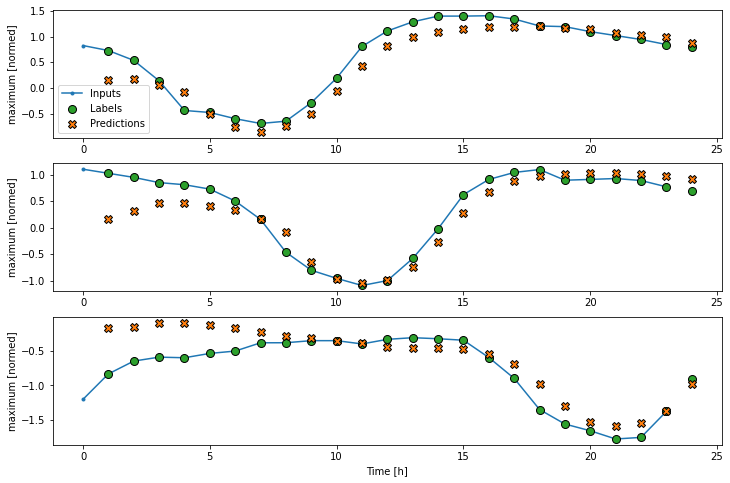

In [44]:
wide_window.plot(lstm_model, plot_col="maximum")

In [47]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([8, 80])
    plt.xlabel('Epoch')
    plt.ylabel('Error [maximum]')
    plt.legend()
    plt.grid(True)

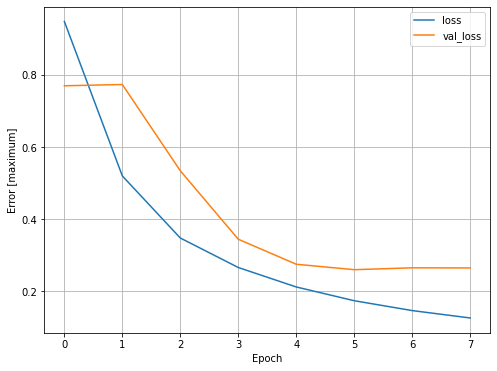

In [48]:
plot_loss(history)